In this notebook we'll be collecting data from the EPA AQS api (https://aqs.epa.gov/aqsweb/documents/data_api.html) for all of the available monitoring sites in Cook county. According to the wikipedia page for AQI values in the United States (https://en.wikipedia.org/wiki/Air_quality_index#United_States) can be based on a number of different measurements. Namely, the $O_3$ (8-hr and 1-hr), $PM_{2.5}$ (24-hr), $PM_{10}$ (24-hr), $CO$ (8-hr), $SO_2$ (1-hr and 24-hr), and $NO_2$ (1-hr) concentrations. The Wikipedia article has details for which values to use in certain scenarios for calculating AQI.

In [9]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import time
%matplotlib inline

### Cook County Data

In [10]:
# api access variables
# state and county codes obtained from the list sample queries on the
url_head = 'https://aqs.epa.gov/data/api'
email = 'garrett.l.ducharme@gmail.com'
with open('C:/Users/ducha/.api_keys/aqs.txt') as f:
    key = json.load(f)["key"]
state = '17'
county = '031'

In [11]:
# Obtaining monitoring sites for cook county
end_point = 'list/sitesByCounty'
url = f'{url_head}/{end_point}?email={email}&key={key}&state={state}&county={county}'
sites = requests.get(url)
sites_df = pd.DataFrame(json.loads(sites.text)['Data'])
sites_df.to_csv('./data/AQS_API/sites.csv')

In [12]:
sites_df[~sites_df.value_represented.isna()]

,code,value_represented
0,0001,VILLAGE GARAGE
13,0014,FARR HALL
21,0022,WASHINGTON HS
24,0026,CERMAK PUMP STATION
30,0032,SOUTH WATER FILTRATION PLANT
40,0042,SEARS TOWER
46,0050,SE POLICE STATION
48,0052,MAYFAIR PUMP STATION
53,0057,SPRINGFIELD PUMP STATION
56,0060,CARVER HS


In [13]:
# Obtaining the valid parameter list
end_point = 'list/classes'
url = f'{url_head}/{end_point}?email={email}&key={key}'
params = requests.get(url)
params_df = pd.DataFrame(json.loads(params.text)['Data'])
params_df.to_csv('./data/AQS_API/params.csv')

All of the polutants that we need to calculate the AQI are contained within the 'CRITERIA' class.

In [14]:
# Obtain all parameters in the criteria class
end_point = 'list/parametersByClass'
pc = 'CRITERIA'
url = f'{url_head}/{end_point}?email={email}&key={key}&pc={pc}'
criteria = requests.get(url)
criteria_df = pd.DataFrame(json.loads(criteria.text)['Data'])
criteria_df.to_csv('./data/AQS_API/criteria.csv')

All meteorological data is contained in the 'MET' class.

In [15]:
end_point = 'list/parametersByClass'
pc = 'MET'
url = f'{url_head}/{end_point}?email={email}&key={key}&pc={pc}'
met_params = requests.get(url)
met_df = pd.DataFrame(json.loads(met_params.text)['Data'])
met_df.to_csv('./data/AQS_API/met_params.csv')

We'll now start obtaining the criteria data and the meteorological data and storing it for future analysis.

In [16]:
# Getting the PM 2.5 data for all sites in Cook county for 2019
param = '88101'
bdate = '20190101'
edate = '20191231'
end_point = 'sampleData/byCounty'
url = f'{url_head}/{end_point}?email={email}&key={key}&param={param}' \
      f'&bdate={bdate}&edate={edate}&state={state}&county={county}'
county_resp = requests.get(url)

In [17]:
county_p25_df = pd.DataFrame(json.loads(county_resp.text)['Data'])
# Keeping only hourly measurements
county_p25_df['sample_frequency'].value_counts()

HOURLY            24864
EVERY 3RD DAY       780
EVERY 6TH DAY       276
EVERY 12TH DAY      130
Name: sample_frequency, dtype: int64

In [18]:
# Looking at the columns to see what we can drop
print(county_p25_df.columns)
county_p25_df.head()

Index(['cbsa_code', 'county', 'county_code', 'date_gmt', 'date_local',
       'date_of_last_change', 'datum', 'detection_limit', 'latitude',
       'longitude', 'method', 'method_code', 'method_type', 'parameter',
       'parameter_code', 'poc', 'qualifier', 'sample_duration',
       'sample_frequency', 'sample_measurement', 'site_number', 'state',
       'state_code', 'time_gmt', 'time_local', 'uncertainty',
       'units_of_measure'],
      dtype='object')


,cbsa_code,county,county_code,date_gmt,date_local,date_of_last_change,datum,detection_limit,latitude,longitude,...,sample_duration,sample_frequency,sample_measurement,site_number,state,state_code,time_gmt,time_local,uncertainty,units_of_measure
0,16980,Cook,031,2019-01-03,2019-01-03,2019-03-12,WGS84,2.0,41.965193,-87.876265,...,24 HOUR,EVERY 3RD DAY,11.9,3103,Illinois,17,06:00,00:00,None,Micrograms/cubic meter (LC)
1,16980,Cook,031,2019-01-06,2019-01-06,2019-03-12,WGS84,2.0,41.965193,-87.876265,...,24 HOUR,EVERY 3RD DAY,5.3,3103,Illinois,17,06:00,00:00,None,Micrograms/cubic meter (LC)
2,16980,Cook,031,2019-01-09,2019-01-09,2019-03-12,WGS84,2.0,41.965193,-87.876265,...,24 HOUR,EVERY 3RD DAY,6.9,3103,Illinois,17,06:00,00:00,None,Micrograms/cubic meter (LC)
3,16980,Cook,031,2019-01-12,2019-01-12,2019-03-12,WGS84,2.0,41.965193,-87.876265,...,24 HOUR,EVERY 3RD DAY,18.6,3103,Illinois,17,06:00,00:00,None,Micrograms/cubic meter (LC)
4,16980,Cook,031,2019-01-15,2019-01-15,2019-03-12,WGS84,2.0,41.965193,-87.876265,...,24 HOUR,EVERY 3RD DAY,9.2,3103,Illinois,17,06:00,00:00,None,Micrograms/cubic meter (LC)


In [19]:
columns_to_drop = ['cbsa_code', 'county', 'county_code', 'date_gmt', 'datum', 'detection_limit',
                   'method', 'method_code', 'parameter_code', 'poc', 'state', 'state_code', 'time_gmt',
                   'uncertainty', 'method_type']
county_p25_df.drop(columns=columns_to_drop, inplace=True)

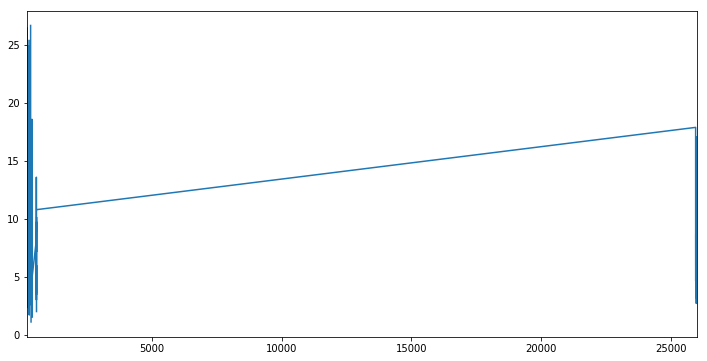

In [35]:
county_p25_df[county_p25_df.sample_frequency == 'EVERY 6TH DAY'].sample_measurement.plot(figsize=(12,6))

### Bakersfield, CA Data

In [23]:
email = 'garrett.l.ducharme@gmail.com'
with open('C:/Users/ducha/.api_keys/aqs.txt') as f:
    key = json.load(f)["key"]
state = '06'
county = '029'

site_dict = {'0003': 'Bakersfield-Health Dept.',
             '0004': 'Bakersfield-Chester Ave.',
             '0010': 'Bakersfield-Golden/M St.',
             '0014': 'Bakersfield-California',
             '0016': 'Bakersfield-Airport',
             '2012': 'Bakersfield-Muni',
             '2019': 'Bakersfield-Westwind',
             '2001': 'Kern Wildlife Refuge'
            }

In [ ]:
from api_helpers import get_data_by_county, get_data_by_site

In [ ]:
kern_pm_2019 = get_data_by_county(email=email, key=key, param='88101', bdate='20190101', edate='20191231',
                                  state='06', county='029')

In [ ]:
kern_pm_2019_df = pd.DataFrame(json.loads(kern_pm_2019.text)['Data'])

In [ ]:
kern_pm_2019_df.site_number.value_counts()

In [135]:
met_params = ['68105', '65102', '68108', '62201', '62103', '61101', '61102',
              '62604', '63301', '66101']

email = 'garrett.l.ducharme@gmail.com'
with open('C:/Users/ducha/.api_keys/aqs.txt') as f:
    key = json.load(f)["key"]
state = '06'
county = '029'
site='0018'
bdates = ['20170101', '20180101', '20190101']
edates = ['20171231', '20181231', '20191231']

met_params_dict = {}

for param in met_params:
    for bdate, edate in zip(bdates, edates):
        temp_resp = get_data_by_site(email, key, param,
                                     bdate, edate, state, county, site)
        temp_df = pd.DataFrame(json.loads(temp_resp.text)['Data'])
        met_params_dict[param] = temp_df
        time.sleep(5)

In [141]:
test_resp = get_data_by_site(email, key, '68105', bdate, edate, state, county, site)

In [143]:
json.loads(test_resp.text)

{'Header': [{'status': 'No data matched your selection',
   'request_time': '2020-02-10T18:53:01-05:00',
   'url': 'https://aqs.epa.gov/data/api/sampleData/bySite?email=garrett.l.ducharme@gmail.com&key=greengazelle22&param=68105&bdate=20190101&edate=20191231&state=06&county=029&site=0018',
   'rows': 0}],
 'Data': []}

In [48]:
kern_pm_2018 = get_data_by_county(email=email, key=key, param='88101', bdate='20180101', edate='20181231',
                                  state='06', county='029')

In [49]:
kern_pm_2018_df = pd.DataFrame(json.loads(kern_pm_2018.text)['Data'])

In [50]:
kern_pm_2018_df.site_number.value_counts()

0011    8760
0018    8760
0014     377
0010     122
0016     119
0015      13
Name: site_number, dtype: int64

In [51]:
kern_pm_2017 = kern_pm_2019 = get_data_by_county(email=email, key=key, param='88101', bdate='20170101', edate='20171231',
                                  state='06', county='029')

In [52]:
kern_pm_2017_df = pd.DataFrame(json.loads(kern_pm_2017.text)['Data'])

In [60]:
kern_pm_2017_df.sample_frequency.value_counts()

HOURLY            10224
EVERY DAY           365
EVERY 3RD DAY       253
EVERY 6TH DAY        65
EVERY 12TH DAY       41
Name: sample_frequency, dtype: int64

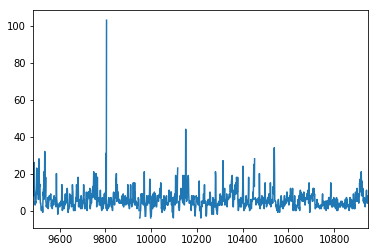

In [146]:
kern_pm_2017_df.loc[(kern_pm_2017_df.sample_frequency == 'HOURLY') & (kern_pm_2017_df.site_number == '0018')] \
['sample_measurement'].plot()

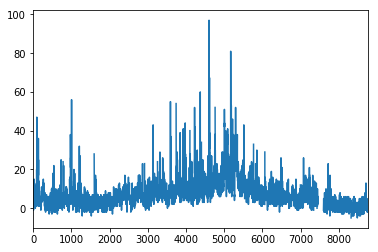

In [145]:
kern_pm_2018_df.loc[(kern_pm_2018_df.sample_frequency == 'HOURLY') & (kern_pm_2018_df.site_number == '0018')] \
['sample_measurement'].plot()

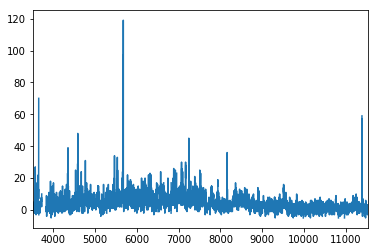

In [144]:
kern_pm_2019_df.loc[(kern_pm_2019_df.sample_frequency == 'HOURLY') & (kern_pm_2019_df.site_number == '0018')] \
['sample_measurement'].plot()